# Stacked LSTMs for Time Series Classification with TensorFlow

We'll now build a slightly deeper model by stacking two LSTM layers using the Quandl stock price data. Furthermore, we will include features that are not sequential in nature, namely indicator variables for identifying the equity and the month.

## Imports

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline

from pathlib import Path
import numpy as np
import pandas as pd
from scipy.stats import spearmanr
from sklearn.metrics import roc_auc_score

import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, LSTM, Input, concatenate, Embedding, Reshape, BatchNormalization
import tensorflow.keras.backend as K

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if gpu_devices:
    print('Using GPU')
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
else:
    print('Using CPU')

Using CPU


In [4]:
idx = pd.IndexSlice
sns.set_style('whitegrid')
np.random.seed(42)

In [5]:
results_path = Path('results', 'lstm_embeddings')
if not results_path.exists():
    results_path.mkdir(parents=True)

## Data

Data produced by the notebook [build_dataset](00_build_dataset.ipynb).

In [6]:
data = pd.read_hdf('data.h5', 'returns_weekly')

In [7]:
data['ticker'] = pd.factorize(data.index.get_level_values('ticker'))[0]

In [8]:
data['month'] = data.index.get_level_values('date').month
data = pd.get_dummies(data, columns=['month'], prefix='month')

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1167341 entries, ('A', Timestamp('2009-01-11 00:00:00')) to ('ZUMZ', Timestamp('2017-12-31 00:00:00'))
Data columns (total 67 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   fwd_returns  1167341 non-null  float64
 1   1            1167341 non-null  float64
 2   2            1167341 non-null  float64
 3   3            1167341 non-null  float64
 4   4            1167341 non-null  float64
 5   5            1167341 non-null  float64
 6   6            1167341 non-null  float64
 7   7            1167341 non-null  float64
 8   8            1167341 non-null  float64
 9   9            1167341 non-null  float64
 10  10           1167341 non-null  float64
 11  11           1167341 non-null  float64
 12  12           1167341 non-null  float64
 13  13           1167341 non-null  float64
 14  14           1167341 non-null  float64
 15  15           1167341 non-null  float64
 16  16           1167

## Train-test split

To respect the time series nature of the data, we set aside the data at the end of the sample as hold-out or test set. More specifically, we'll use the data for 2017.

In [10]:
window_size=52
sequence = list(range(1, window_size+1))
ticker = 1
months = 12
n_tickers = data.ticker.nunique()

In [11]:
train_data = data.drop('fwd_returns', axis=1).loc[idx[:, :'2016'], :]
test_data = data.drop('fwd_returns', axis=1).loc[idx[:, '2017'],:]

For each train and test dataset, we generate a list with three input arrays containing the return series, the stock ticker (converted to integer values), and the month (as an integer), as shown here:

In [12]:
X_train = [
    train_data.loc[:, sequence].values.reshape(-1, window_size , 1),
    train_data.ticker,
    train_data.filter(like='month')
]
y_train = train_data.label
[x.shape for x in X_train], y_train.shape

([(1035424, 52, 1), (1035424,), (1035424, 12)], (1035424,))

In [13]:
# keep the last year for testing
X_test = [
    test_data.loc[:, list(range(1, window_size+1))].values.reshape(-1, window_size , 1),
    test_data.ticker,
    test_data.filter(like='month')
]
y_test = test_data.label
[x.shape for x in X_test], y_test.shape

([(131917, 52, 1), (131917,), (131917, 12)], (131917,))

##  Define the Model Architecture

The functional API of Keras makes it easy to design architectures with multiple inputs and outputs. This example illustrates a network with three inputs, as follows:

- A two stacked LSTM layers with 25 and 10 units respectively
- An embedding layer that learns a 10-dimensional real-valued representation of the equities
- A one-hot encoded representation of the month

This can be constructed using just a few lines - see e.g., 
- the [general Keras documentation](https://keras.io/getting-started/sequential-model-guide/), 
- the [LSTM documentation](https://keras.io/layers/recurrent/).

Make sure you are initializing your optimizer given the [keras-recommended approach for RNNs](https://keras.io/optimizers/) 

We begin by defining the three inputs with their respective shapes, as described here:

In [14]:
K.clear_session()

In [15]:
n_features = 1

In [16]:
returns = Input(shape=(window_size, n_features),
                name='Returns')

tickers = Input(shape=(1,),
                name='Tickers')

months = Input(shape=(12,),
               name='Months')

### LSTM Layers

To define stacked LSTM layers, we set the `return_sequences` keyword to `True`. This ensures that the first layer produces an output that conforms to the expected three-dimensional input format. Note that we also use dropout regularization and how the functional API passes the tensor outputs from one layer to the subsequent layer:

In [17]:
lstm1_units = 25
lstm2_units = 10

In [18]:
lstm1 = LSTM(units=lstm1_units, 
             input_shape=(window_size, 
                          n_features), 
             name='LSTM1', 
             dropout=.2,
             return_sequences=True)(returns)

lstm_model = LSTM(units=lstm2_units, 
             dropout=.2,
             name='LSTM2')(lstm1)

### Embedding Layer

The embedding layer requires the `input_dim` keyword, which defines how many embeddings the layer will learn, the `output_dim` keyword, which defines the size of the embedding, and the `input_length` keyword to set the number of elements passed to the layer (here only one ticker per sample). 

To combine the embedding layer with the LSTM layer and the months input, we need to reshape (or flatten) it, as follows:

In [19]:
ticker_embedding = Embedding(input_dim=n_tickers, 
                             output_dim=5, 
                             input_length=1)(tickers)
ticker_embedding = Reshape(target_shape=(5,))(ticker_embedding)

### Concatenate Model components

Now we can concatenate the three tensors and add fully-connected layers to learn a mapping from these learned time series, ticker, and month indicators to the outcome, a positive or negative return in the following week, as shown here:

In [20]:
merged = concatenate([lstm_model, 
                      ticker_embedding, 
                      months], name='Merged')

bn = BatchNormalization()(merged)
hidden_dense = Dense(10, name='FC1')(bn)

output = Dense(1, name='Output', activation='sigmoid')(hidden_dense)

rnn = Model(inputs=[returns, tickers, months], outputs=output)

The summary lays out this slightly more sophisticated architecture with 29,371 parameters, as follows:

In [21]:
rnn.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Returns (InputLayer)            [(None, 52, 1)]      0                                            
__________________________________________________________________________________________________
Tickers (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
LSTM1 (LSTM)                    (None, 52, 25)       2700        Returns[0][0]                    
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1, 5)         12445       Tickers[0][0]                    
______________________________________________________________________________________________

## Train the Model

We compile the model to compute a custom auc metric as follows:

In [22]:
optimizer = tf.keras.optimizers.RMSprop(lr=0.001,
                                        rho=0.9,
                                        epsilon=1e-08,
                                        decay=0.0)

In [23]:
rnn.compile(loss='binary_crossentropy',
            optimizer=optimizer,
            metrics=['accuracy', 
                     tf.keras.metrics.AUC(name='AUC')])

In [24]:
lstm_path = (results_path / 'lstm.classification.h5').as_posix()

checkpointer = ModelCheckpoint(filepath=lstm_path,
                               verbose=1,
                               monitor='val_AUC',
                               mode='max',
                               save_best_only=True)

In [25]:
early_stopping = EarlyStopping(monitor='val_AUC', 
                              patience=5,
                              restore_best_weights=True,
                              mode='max')

In [26]:
training = rnn.fit(X_train,
                   y_train,
                   epochs=50,
                   batch_size=32,
                   validation_data=(X_test, y_test),
                   callbacks=[early_stopping, checkpointer],
                   verbose=1)

Epoch 1/50
32356/32357 [============================>.] - ETA: 0s - loss: 0.6892 - accuracy: 0.5375 - AUC: 0.5504
Epoch 00001: val_AUC improved from -inf to 0.61860, saving model to results/lstm_embeddings/lstm.classification.h5
32357/32357 [==============================] - 335s 10ms/step - loss: 0.6892 - accuracy: 0.5375 - AUC: 0.5504 - val_loss: 0.6701 - val_accuracy: 0.5826 - val_AUC: 0.6186
Epoch 2/50
32354/32357 [============================>.] - ETA: 0s - loss: 0.6855 - accuracy: 0.5493 - AUC: 0.5680
Epoch 00002: val_AUC improved from 0.61860 to 0.63500, saving model to results/lstm_embeddings/lstm.classification.h5
32357/32357 [==============================] - 338s 10ms/step - loss: 0.6855 - accuracy: 0.5493 - AUC: 0.5680 - val_loss: 0.6668 - val_accuracy: 0.5902 - val_AUC: 0.6350
Epoch 3/50
32352/32357 [============================>.] - ETA: 0s - loss: 0.6857 - accuracy: 0.5488 - AUC: 0.5671
Epoch 00003: val_AUC improved from 0.63500 to 0.63709, saving model to results/lstm_e

Training stops after 18 epochs, producing a test area under the curve (AUC) of 0.63 for the best model with 13 rounds of training (each of which takes around three minutes on a single GPU).

In [27]:
loss_history = pd.DataFrame(training.history)

In [28]:
def which_metric(m):
    return m.split('_')[-1]

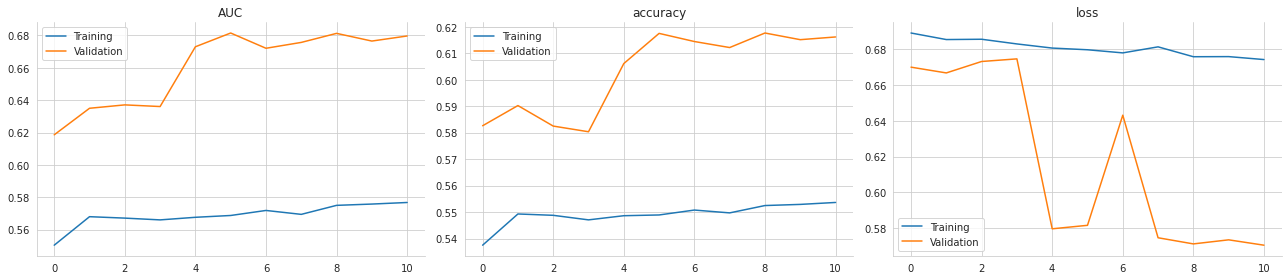

In [29]:
fig, axes = plt.subplots(ncols=3, figsize=(18,4))
for i, (metric, hist) in enumerate(loss_history.groupby(which_metric, axis=1)):
    hist.plot(ax=axes[i], title=metric)
    axes[i].legend(['Training', 'Validation'])

sns.despine()
fig.tight_layout()
fig.savefig(results_path / 'lstm_stacked_classification', dpi=300);

## Evaluate model performance

In [30]:
test_predict = pd.Series(rnn.predict(X_test).squeeze(), index=y_test.index)

In [31]:
roc_auc_score(y_score=test_predict, y_true=y_test)

0.6815303447045473

In [32]:
((test_predict>.5) == y_test).astype(int).mean()

0.6174943335582223

In [33]:
spearmanr(test_predict, y_test)[0]

0.3105869204256358